# Demo:  Predicting Glucose Levels using Mulitple Linear Regression

In this demo, you will learn how to:
* Fit multiple linear regression models using python's `sklearn` pachage.  
* Split data into training and test.
* Manipulate and visualize multivariable arrays.

We first load the packages as usual.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Diabetes Data Example
To illustrate the concepts, we load the well-known diabetes data set.  This dataset is included in the `sklearn.datasets` module and can be loaded as follows.

In [6]:
from sklearn import datasets, linear_model

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

The target values `y` represent the blood glucose levels that we wish to predict.  The number of attributes and samples are computed from the shape:

In [7]:
nsamp, natt = X.shape
print("num samples={0:d}  num attributes={1:d}".format(nsamp,natt))

num samples=442  num attributes=10


## Using Simple Linear Regression for Each Feature Individually

As a first attempt to predict the glucouse level, we could try *one attribute at a time*.  That is, for each attribute $x_k$, we could attempt to fit a [simple linear regression](../simp_lin_reg/readme.md) model:
$$ \hat{y} = \beta_{0,k} + \beta_{1,k}x_k$$
where $\beta_{0,k}$ and $\beta_{1,k}$ are the coefficients in the simple linear regression model using only the attribute $x_k$.

Now, we saw in class, that the goodness of fit in a simple linear regression model is given by the coefficient of determination.  Let $R_k^2$ be the coefficient for predicting $y$ from the $k$-th predictor $x_k$:
$$R^2_k = \frac{|s_{x_k,y}|^2}{s_{x_k}^2 s_y^2}.$$
The following code computes $R^2_k$ for each variable $k$ as well as the coefficients in the linear model, $\beta_{0,k}$ and $\beta_{1,k}$

In [8]:
ym = np.mean(y)
syy = np.mean((y-ym)**2)
Rsq = np.zeros(natt)
beta0 = np.zeros(natt)
beta1 = np.zeros(natt)
for k in range(natt):
    xm = np.mean(X[:,k])
    sxy = np.mean((X[:,k]-xm)*(y-ym))
    sxx = np.mean((X[:,k]-xm)**2)
    beta1[k] = sxy/sxx
    beta0[k] = ym - beta1[k]*xm
    Rsq[k] = (sxy)**2/sxx/syy
    
    print("{0:2d}  Rsq={1:f}".format(k,Rsq[k]))
    

 0  Rsq=0.035302
 1  Rsq=0.001854
 2  Rsq=0.343924
 3  Rsq=0.194908
 4  Rsq=0.044954
 5  Rsq=0.030295
 6  Rsq=0.155859
 7  Rsq=0.185290
 8  Rsq=0.320224
 9  Rsq=0.146294


We see that the best $R^2_k = 0.34$.  That is, only about 34% of the variance is explained by a linear model with any one variable.  We can see this somewhat poor fit in the scatter plot as well where there is a significat variation from the regression line.

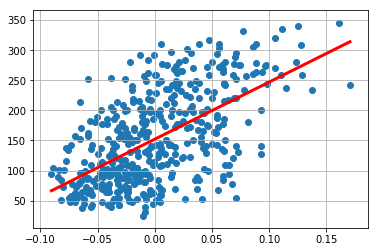

In [9]:
# Find the index of the single variable with the best R^2
imax = np.argmax(Rsq)

# Regression line over the range of x values
xmin = np.min(X[:,imax])
xmax = np.max(X[:,imax])
ymin = beta0[imax] + beta1[imax]*xmin
ymax = beta0[imax] + beta1[imax]*xmax
plt.plot([xmin,xmax], [ymin,ymax], 'r-', linewidth=3)

# Scatter plot of points
plt.scatter(X[:,imax],y)
plt.grid()

Note that the calculations above could have been done without a for-loop using Python broadcasting:

In [7]:
# Remove the means
ym = np.mean(y)
y1 = y-ym
Xm = np.mean(X,axis=0)
X1 = X - Xm[None,:]

# Compute the correlations per features
syy = np.mean(y1**2)
Sxx = np.mean(X1**2,axis=0)
Sxy = np.mean(X1*y1[:,None],axis=0)

# Compute the coefficients and R^2 value per feature
beta1 = Sxy/Sxx
beta0 = ym - beta1*Xm
Rsq = Sxy**2/Sxx/syy

## Improvements with a Multiple Variable Linear Model

One possible way to try to improve the fit is to use multiple variables at the same time.  We can fit the multipe linear model using the `sklearn` package.  

For reasons that we will explain in the next demo, we need to split the data into two parts:  one part for training the model and a second part for testing the fit.  In this example, we will use `ns_test=300` samples for training and the remaining `ns_test=442-300=142` for testing.

In [8]:
ns_train = 300
ns_test = nsamp - ns_train
X_tr = X[:ns_train,:]     # Gets the first ns_train rows of X
y_tr = y[:ns_train]       # Gets the correspoinding rows of y

To fit the linear model, we first create a regression object and the fit the data with regression object.

In [9]:
regr = linear_model.LinearRegression()
regr.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

You can see the coefficients

In [10]:
regr.coef_

array([ -16.57607993, -254.66532396,  560.98630022,  278.91811152,
       -393.41357305,   97.05460405,  -19.0023093 ,  169.46450327,
        632.95050374,  114.21638941])

We next compute the RSS (per sample) and the R^2 on the training data

In [12]:
y_tr_pred = regr.predict(X_tr)
RSS_tr = np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
Rsq_tr = 1-RSS_tr
print("RSS per sample = {0:f}".format(RSS_tr))
print("R^2 =            {0:f}".format(Rsq_tr))

RSS per sample = 0.485281
R^2 =            0.514719


We see this is higher than the best single variable model -- more than 51% of the target variance is explained by the model instead of just 34% for the best single variable model.  

We also create a scatter plot of predicted vs. actual

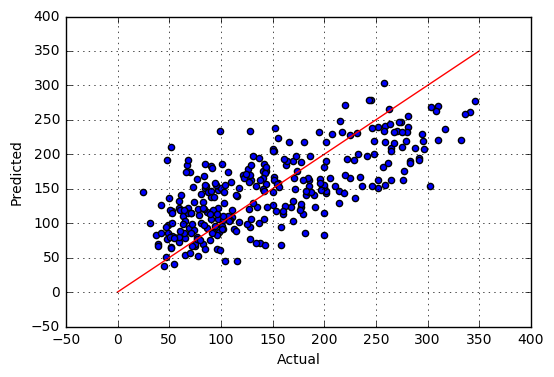

In [11]:
plt.scatter(y_tr,y_tr_pred)
plt.plot([0,350],[0,350],'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()

## Validate on Test Data

As we will explain in the next lab, one should not evaluate the performance of a model on the data on which it is trained.  It is important to see how the model works on *new* data that is independent of the training data set.  For this reason, we will evaluate the model on the *test* samples that were not used in training.

In [15]:
X_test = X[ns_train:,:]
y_test = y[ns_train:]
y_test_pred = regr.predict(X_test)
RSS_test = np.mean((y_test_pred-y_test)**2)/(np.std(y_test)**2)
Rsq_test = 1-RSS_test
print("RSS per sample = {0:f}".format(RSS_test))
print("R^2 =            {0:f}".format(Rsq_test))

RSS per sample = 0.492801
R^2 =            0.507199


We see that the model predicts new samples almost as well as it did the training samples.  We can also plot the fit on the test data.

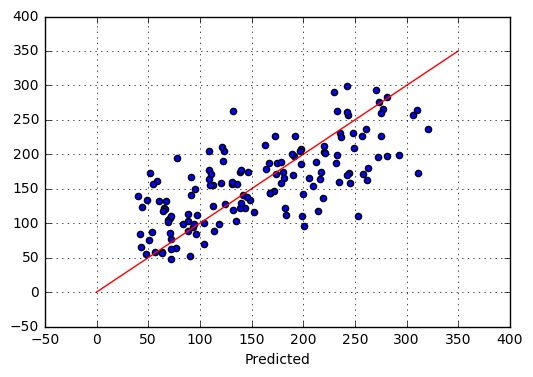

In [16]:
plt.scatter(y_test,y_test_pred)
plt.plot([0,350],[0,350],'r')
plt.xlabel('Actual')
plt.xlabel('Predicted')
plt.grid()

## Manually computing the coefficients

We can manually compute the regression coefficients using the least-squares matrix formula in class.  Of course, using the `sklearn` package is easier.  I illustrate the manual computation only to show what is happening "under the hood" of the lienar regression routine. 

To compute the coefficients manually, we first construct the matrix $\mathbf{A} = [ \mathbf{1} ~ \mathbf{X} ]$.  This is performed with the `ones` command and `hstack`.  Note that after we do this, `A` has 11 columns -- one more column that the data matrix `X_tr`.

In [17]:
ones = np.ones((ns_train,1))
A = np.hstack((ones,X_tr))
A.shape

(300, 11)

We next use the `lstsq` method to solve $\mathbf{y} \approx \mathbf{A\beta}$.  This will find the desired least-squares fit.

In [18]:
out = np.linalg.lstsq(A,y_tr)
beta = out[0]

We can see the coefficients

In [19]:
beta

array([ 152.34786452,  -16.57607993, -254.66532396,  560.98630022,
        278.91811152, -393.41357305,   97.05460405,  -19.0023093 ,
        169.46450327,  632.95050374,  114.21638941])

We see that `beta[0]` mathches the intercept in `regr.intercept_` from the regression fit and `beta[1:]` matches the coefficients in `regr.coef_`.

In [20]:
regr.coef_

array([ -16.57607993, -254.66532396,  560.98630022,  278.91811152,
       -393.41357305,   97.05460405,  -19.0023093 ,  169.46450327,
        632.95050374,  114.21638941])

In [21]:
regr.intercept_

152.34786451820108